# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [2]:
from pprint import pprint

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

609

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
firstCity = cities[0]
firstCity
        

'kutum'

In [5]:
# Build query URL
units = "imperial"
url = f"http://api.openweathermap.org/data/2.5/weather?q={firstCity}&appid={weather_api_key}&units={units}"

url

'http://api.openweathermap.org/data/2.5/weather?q=kutum&appid=b9243e2d7b71044b8840d4590278accb&units=imperial'

In [6]:
response = requests.get(url).json()
pprint(response)

{'base': 'stations',
 'clouds': {'all': 15},
 'cod': 200,
 'coord': {'lat': 14.2, 'lon': 24.67},
 'dt': 1588644536,
 'id': 371745,
 'main': {'feels_like': 62.22,
          'grnd_level': 883,
          'humidity': 15,
          'pressure': 1009,
          'sea_level': 1009,
          'temp': 69.37,
          'temp_max': 69.37,
          'temp_min': 69.37},
 'name': 'Kutum',
 'sys': {'country': 'SD', 'sunrise': 1588651040, 'sunset': 1588696715},
 'timezone': 7200,
 'weather': [{'description': 'few clouds',
              'icon': '02n',
              'id': 801,
              'main': 'Clouds'}],
 'wind': {'deg': 56, 'speed': 3.76}}


In [7]:
response["clouds"]["all"]

15

In [8]:
lats = []
longs = []
temps = []
humids = []
pressures = []
winds = []
clouds = []

citiesFound = []
counter = 0

In [9]:
for city in cities:
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units={units}"
    
    try:
        response = requests.get(url).json()
    
        code = response["cod"]

        if code == 200:  
            citiesFound.append(city)
            lats.append(response["coord"]["lat"])
            longs.append(response["coord"]["lon"])
            temps.append(response["main"]["temp"])
            humids.append(response["main"]["humidity"])
            pressures.append(response["main"]["pressure"])

            winds.append(response["wind"]["speed"])
            clouds.append(response["clouds"]["all"])

        if counter % 50 == 0:
            print(counter)
    
    except Exception as e:
        print(e)
    
    counter += 1
    time.sleep(1)

0
50
100
150
200
250
300
350
400
450
500
550
600


In [10]:
counter

609

In [11]:
df = pd.DataFrame()
df["cities"] = citiesFound
df["latitude"] = lats
df["longitude"] = longs
df["temperature"] = temps
df["humidity"] = humids
df["pressure"] = pressures
df["wind_speed"] = winds
df["cloudiness"] = clouds

df.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,kutum,14.20,24.67,69.37,15,1009,3.76,15
1,provideniya,64.38,-173.30,38.68,63,1017,1.45,0
2,norman wells,65.28,-126.83,39.20,60,1023,16.11,75
3,mahon,39.89,4.27,62.60,88,1014,4.70,65
4,tuktoyaktuk,69.45,-133.04,17.60,78,1026,16.11,20


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [12]:
len(df)

566

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [13]:
df.describe()

,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,19.608763,13.790813,62.197774,67.070671,1013.240283,7.989876,49.367491
std,33.072896,90.099130,18.143965,22.119193,12.983401,5.608832,39.608875
min,-54.800000,-175.200000,5.000000,6.000000,742.000000,0.510000,0.000000
25%,-8.460000,-64.725000,48.512500,54.000000,1010.000000,3.675000,3.000000
50%,24.795000,20.455000,63.815000,73.000000,1013.000000,6.710000,42.000000
75%,46.210000,93.312500,77.947500,83.000000,1017.000000,10.970000,90.000000
max,78.220000,179.320000,93.990000,100.000000,1030.000000,47.200000,100.000000


In [14]:
#  Get the indices of cities that have humidity over 100%.
mask = df.humidity <= 100
df_sub = df.loc[mask].reset_index(drop=True)

df_sub.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,kutum,14.20,24.67,69.37,15,1009,3.76,15
1,provideniya,64.38,-173.30,38.68,63,1017,1.45,0
2,norman wells,65.28,-126.83,39.20,60,1023,16.11,75
3,mahon,39.89,4.27,62.60,88,1014,4.70,65
4,tuktoyaktuk,69.45,-133.04,17.60,78,1026,16.11,20


In [15]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


In [16]:
# Extract relevant fields from the data frame


# Export the City_Data into a csv
df_sub.to_csv("weatherData.csv", index=False)

In [17]:
df = pd.read_csv("weatherData.csv")

df.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,kutum,14.20,24.67,69.37,15,1009,3.76,15
1,provideniya,64.38,-173.30,38.68,63,1017,1.45,0
2,norman wells,65.28,-126.83,39.20,60,1023,16.11,75
3,mahon,39.89,4.27,62.60,88,1014,4.70,65
4,tuktoyaktuk,69.45,-133.04,17.60,78,1026,16.11,20


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

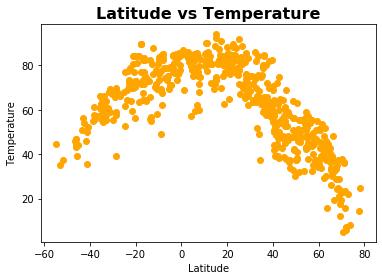

In [18]:
plt.scatter(df.latitude, df.temperature, color="purple")
plt.xlabel("Latitude")
plt.ylabel("Temperature")
plt.title("Latitude vs Temperature", fontsize=16, fontweight="bold")
plt.show()

## Latitude vs. Humidity Plot

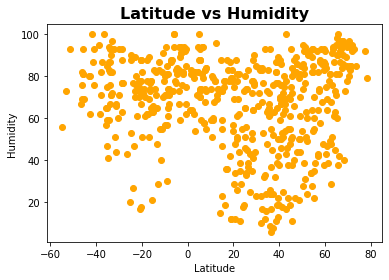

In [19]:
plt.scatter(df.latitude, df.humidity, color="red")
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("Latitude vs Humidity", fontsize=16, fontweight="bold")
plt.show()

## Latitude vs. Cloudiness Plot

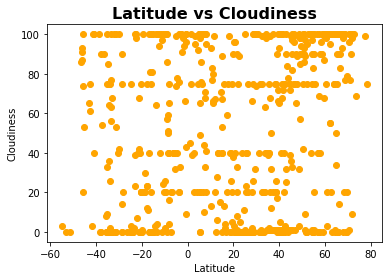

In [20]:
plt.scatter(df.latitude, df.cloudiness, color="green")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("Latitude vs Cloudiness", fontsize=16, fontweight="bold")
plt.show()

## Latitude vs. Wind Speed Plot

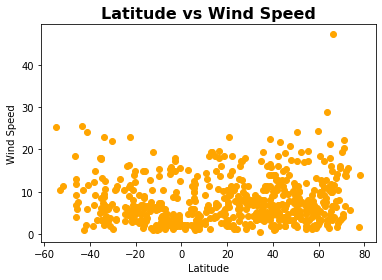

In [21]:
plt.scatter(df.latitude, df.wind_speed, color="blue")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.title("Latitude vs Wind Speed", fontsize=16, fontweight="bold")
plt.show()

## Linear Regression

In [22]:
#Mask
northernHemi_mask = df.latitude >= 0
df_north = df.loc[northernHemi_mask].reset_index(drop=True)

df_north.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,kutum,14.20,24.67,69.37,15,1009,3.76,15
1,provideniya,64.38,-173.30,38.68,63,1017,1.45,0
2,norman wells,65.28,-126.83,39.20,60,1023,16.11,75
3,mahon,39.89,4.27,62.60,88,1014,4.70,65
4,tuktoyaktuk,69.45,-133.04,17.60,78,1026,16.11,20


In [23]:
southernHemi_mask = df.latitude < 0
df_south = df.loc[southernHemi_mask].reset_index(drop=True)

df_south.head()

,cities,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
0,avarua,-21.21,-159.78,80.60,78,1012,5.82,0
1,rikitea,-23.12,-134.97,73.33,73,1017,16.20,100
2,bluff,-46.60,168.33,45.93,67,1011,18.45,86
3,comodoro rivadavia,-45.87,-67.50,44.60,81,1020,6.93,20
4,camocim,-2.90,-40.84,76.66,94,1012,18.01,100


In [24]:
import seaborn as sn

In [25]:
north_corrs = df_north.corr()
north_corrs

,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
latitude,1.000000,-0.019905,-0.871007,0.137005,0.077479,0.140480,0.200953
longitude,-0.019905,1.000000,0.020098,0.106936,-0.130512,-0.180953,0.211912
temperature,-0.871007,0.020098,1.000000,-0.340371,-0.112796,-0.068251,-0.233121
humidity,0.137005,0.106936,-0.340371,1.000000,-0.047463,0.006505,0.281521
pressure,0.077479,-0.130512,-0.112796,-0.047463,1.000000,0.006723,-0.105279
wind_speed,0.140480,-0.180953,-0.068251,0.006505,0.006723,1.000000,0.008332
cloudiness,0.200953,0.211912,-0.233121,0.281521,-0.105279,0.008332,1.000000


In [26]:
south_corrs = df_south.corr()
south_corrs

,latitude,longitude,temperature,humidity,pressure,wind_speed,cloudiness
latitude,1.000000,-0.127173,0.781352,0.007762,-0.264739,-0.252852,0.111289
longitude,-0.127173,1.000000,-0.044959,-0.282669,0.139438,0.252738,0.085279
temperature,0.781352,-0.044959,1.000000,-0.094589,-0.250380,-0.099528,0.055781
humidity,0.007762,-0.282669,-0.094589,1.000000,-0.223327,-0.195755,0.135895
pressure,-0.264739,0.139438,-0.250380,-0.223327,1.000000,-0.047486,-0.368090
wind_speed,-0.252852,0.252738,-0.099528,-0.195755,-0.047486,1.000000,0.078939
cloudiness,0.111289,0.085279,0.055781,0.135895,-0.368090,0.078939,1.000000


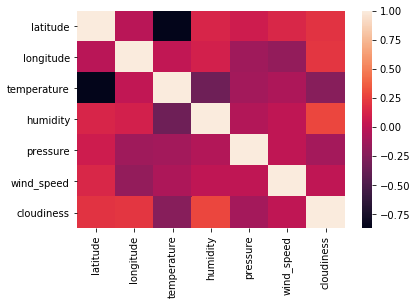

In [27]:
sn.heatmap(north_corrs)

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7586525552957322
The p-value is: 6.718474392588349e-121


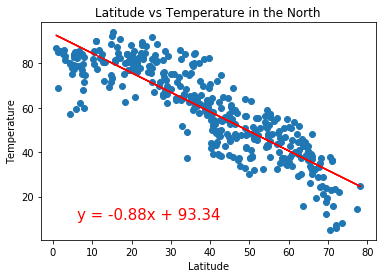

In [28]:
 # Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['temperature']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title("Latitude vs Temperature in the North")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.6105105181401015
The p-value is: 4.3836051099022e-38


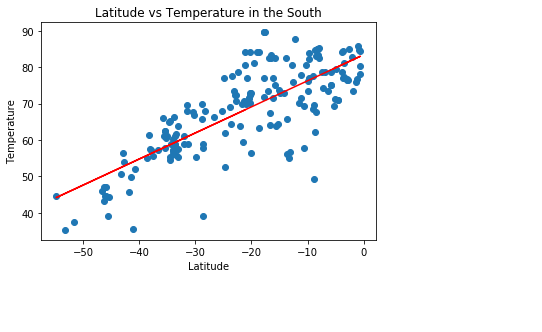

In [29]:
 # Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['temperature']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Temperature')
plt.title("Latitude vs Temperature in the South")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.018770430747091737
The p-value is: 0.006949996513759639


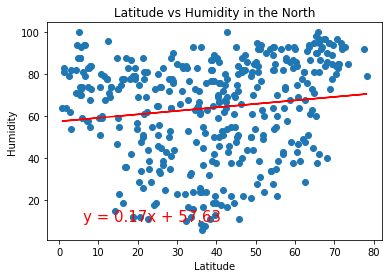

In [30]:
 # Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['humidity']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.title("Latitude vs Humidity in the North")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 6.0254171759281056e-05
The p-value is: 0.9178619977368097


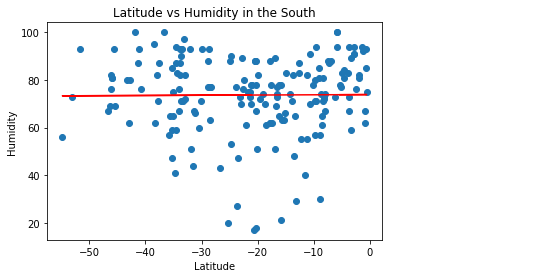

In [31]:
# Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['humidity']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.title("Latitude vs Humidity in the South")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.04038220146549683
The p-value is: 6.859367298981955e-05


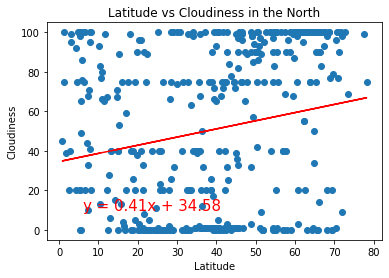

In [32]:
# Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.title("Latitude vs Cloudiness in the North")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.012385218576226369
The p-value is: 0.1380415235491818


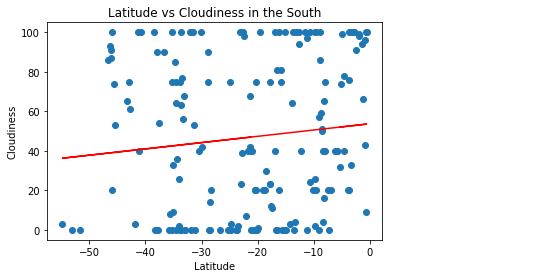

In [33]:
# Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['cloudiness']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.title("Latitude vs Cloudiness in the South")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.01973464023353215
The p-value is: 0.005633768924478145


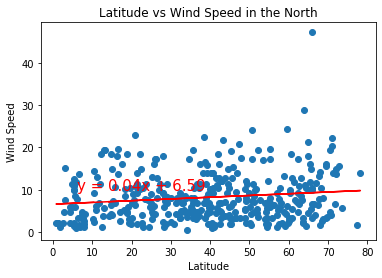

In [34]:
# Print out the r-squared value along with the plot.
x_values = df_north['latitude']
y_values = df_north['wind_speed']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.title("Latitude vs Wind Speed in the North")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.06393420117266184
The p-value is: 0.0006380698734219996


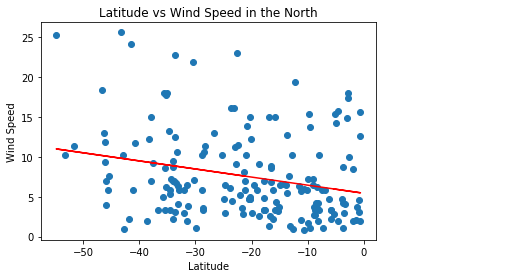

In [35]:
# Print out the r-squared value along with the plot.
x_values = df_south['latitude']
y_values = df_south['wind_speed']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.title("Latitude vs Wind Speed in the North")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is: {pvalue}")
plt.show()

In [36]:
import statsmodels.api as sm

In [37]:
X = df_north[["latitude", "pressure", "cloudiness", "wind_speed"]]
y = df_north[["temperature"]]

In [38]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     315.8
Date:                Mon, 04 May 2020   Prob (F-statistic):          1.10e-119
Time:                        21:21:17   Log-Likelihood:                -1419.3
No. Observations:                 387   AIC:                             2849.
Df Residuals:                     382   BIC:                             2868.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.4614     32.851      4.976      0.000      98.871     228.052
latitude      -0.8690      0.026    -33.696      0.000      -0.920      -0.818
pressure      -0.0695      0.032     -2.143      0.033      -0.133      -0.006
cloudiness    -0.0325      0.012     -2.608      0.009      -0.057      -0.008
wind_speed     0.1854      0.086      2.153      0.032       0.016       0.355
==============================================================================
Omnibus:                        8.405   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.314
Skew:                          -0.331   Prob(JB):                       0.0157
Kurtosis:                       3.276   Cond. No.                     6.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

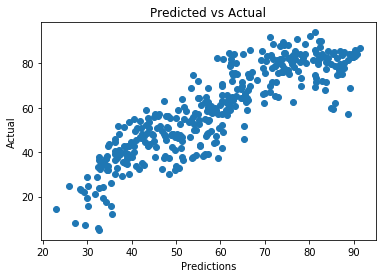

In [39]:
plt.scatter(predictions, y)
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

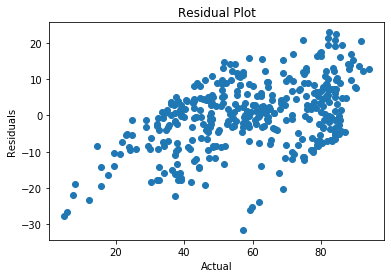

In [40]:
residuals = y.temperature - predictions

plt.scatter(y, residuals)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()